In [1]:
import numpy as np
import pandas as pd
from pandas import Series
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline

In [2]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('/Users/nikmag/Desktop/USC/INF_552_ML/Project/Data/train.csv').fillna(' ')
test = pd.read_csv('/Users/nikmag/Desktop/USC/INF_552_ML/Project/Data/test.csv').fillna(' ')

for class_ in classes:
    print(r'Event rate for %s' % class_)
    print(str(np.round(float(train[class_].value_counts()[1]*100)/len(train),2))+'%')

Event rate for toxic
9.58%
Event rate for severe_toxic
1.0%
Event rate for obscene
5.29%
Event rate for threat
0.3%
Event rate for insult
4.94%
Event rate for identity_hate
0.88%


In [3]:
text = pd.concat([train['comment_text'],test['comment_text']]).reset_index(drop=True)

In [4]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'[a-z]{3,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_df = 50000,
    max_features=1000)

tfidf.fit(text)
train_features = tfidf.transform(train['comment_text'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_features.toarray(), train[classes], test_size=0.3, random_state=0)

### Multinomial NB 

1. max_df = 50000, max_features = 300, ngram_range = (1,2), AVG AUC = 0.92
2. max_df = 50000, max_features = 600, ngram_range = (1,2), AVG AUC = 0.94
3. max_df = 50000, max_features = 1000, ngram_range = (1,2), AVG AUC = 0.96

toxic
severe_toxic
obscene
threat
insult
identity_hate


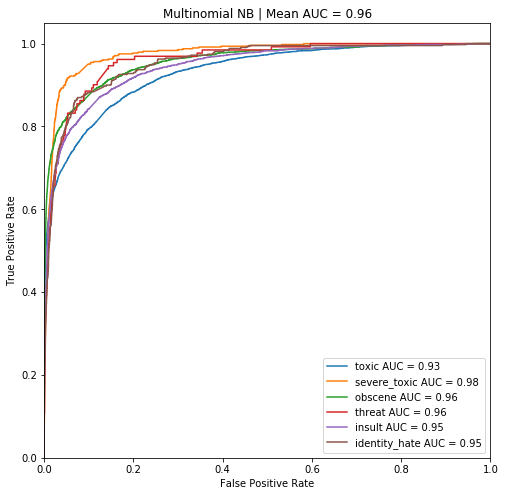

In [74]:
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    print(class_)
    model = MultinomialNB()
    model.fit(X_train, y_train[class_])
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Multinomial NB | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)
df_match = pd.DataFrame(match)
df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0

In [75]:
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

hamming score = 0.89


### Logistic Regression

1. max_df = 50000, max_features = 1000, ngram_range = (1,2), AVG AUC = 0.96

CV Score for toxic = 0.935923432464
CV Score for severe_toxic = 0.974911695191
CV Score for obscene = 0.968615226051
CV Score for threat = 0.961656446714
CV Score for insult = 0.952202503154
CV Score for identity_hate = 0.95036666361


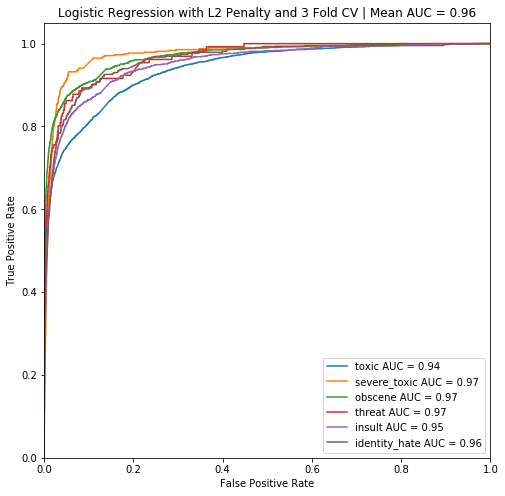

In [72]:
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    logR = LogisticRegression(solver='sag',penalty='l2')
    model = GridSearchCV(estimator=logR,cv=3,param_grid={'C':[0.01,0.1,1,10]},scoring='roc_auc')
    model.fit(X_train, y_train[class_])
    print('CV Score for {} = {}'.format(class_, model.best_score_))
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Logistic Regression with L2 Penalty and 3 Fold CV | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)

df_match = pd.DataFrame(match)

df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0

In [73]:
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

hamming score = 0.92


### Multinomial NB - Different Settings

### Ngram = (1,2)

max_features = 2000

In [4]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'[a-z]{3,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_df = 50000,
    max_features=2000)

tfidf.fit(text)
train_features = tfidf.transform(train['comment_text'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_features.toarray(), train[classes], test_size=0.3, random_state=0)

toxic
severe_toxic
obscene
threat
insult
identity_hate


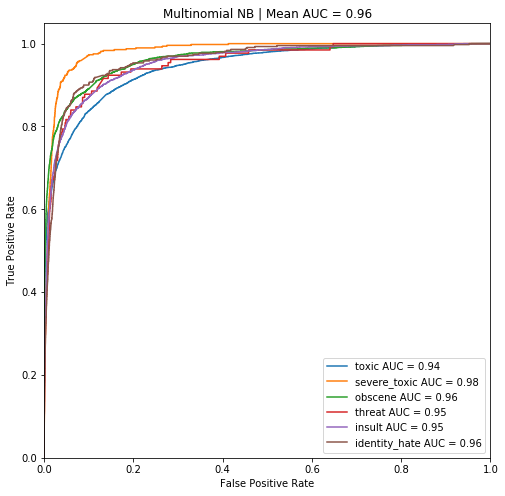

In [6]:
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    print(class_)
    model = MultinomialNB()
    model.fit(X_train, y_train[class_])
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Multinomial NB | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)
df_match = pd.DataFrame(match)
df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0

In [7]:
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

hamming score = 0.91


max_features = 5000

toxic
severe_toxic
obscene
threat
insult
identity_hate
hamming score = 0.91


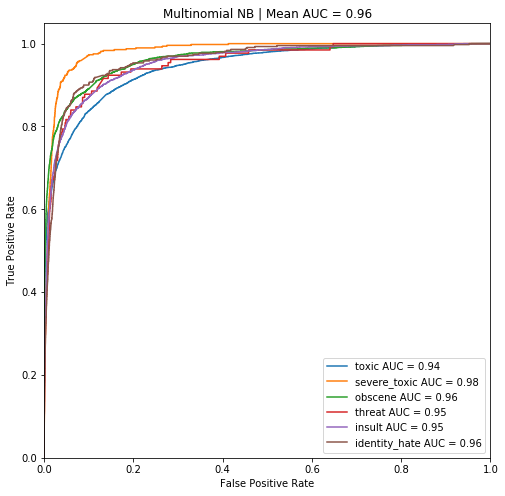

In [9]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'[a-z]{3,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_df = 50000,
    max_features=5000)

tfidf.fit(text)
train_features = tfidf.transform(train['comment_text'])
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    print(class_)
    model = MultinomialNB()
    model.fit(X_train, y_train[class_])
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Multinomial NB | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)
df_match = pd.DataFrame(match)
df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

### Max features = 1000

ngram = (1,3)

toxic
severe_toxic
obscene
threat
insult
identity_hate
hamming score = 0.91


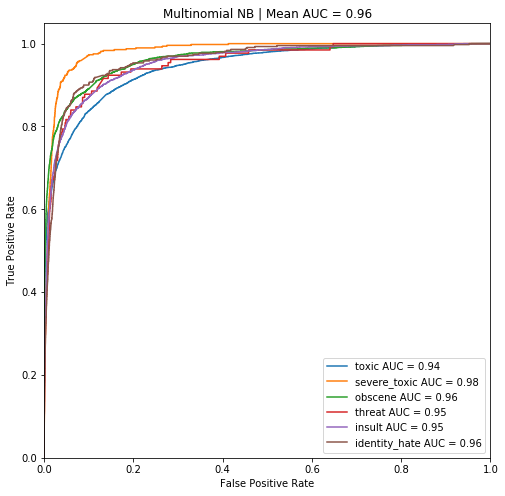

In [10]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'[a-z]{3,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_df = 50000,
    max_features=1000)

tfidf.fit(text)
train_features = tfidf.transform(train['comment_text'])
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    print(class_)
    model = MultinomialNB()
    model.fit(X_train, y_train[class_])
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Multinomial NB | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)
df_match = pd.DataFrame(match)
df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

ngram = (1,4)

toxic
severe_toxic
obscene
threat
insult
identity_hate
hamming score = 0.91


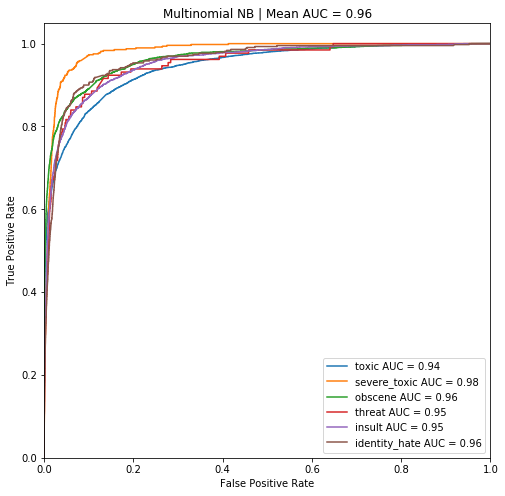

In [ ]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'[a-z]{3,}',
    stop_words='english',
    ngram_range=(1, 4),
    max_df = 50000,
    max_features=1000)

tfidf.fit(text)
train_features = tfidf.transform(train['comment_text'])
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    print(class_)
    model = MultinomialNB()
    model.fit(X_train, y_train[class_])
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Multinomial NB | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)
df_match = pd.DataFrame(match)
df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

Settings (1,5) and (1,6) were also applied on the data but gave similar results, so have not been documented in the code.